In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from skimage import feature

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# 12345->01234
# delete 4, delete 1, 23->1
label = np.load("Cas.npy")
label = label.reshape(4989,1)
label = label - 1

index = np.where(label==4)
label = np.delete(label, np.where(label == 4))

index_0 = np.where(label==0)
index_0 = index_0[0][:2800]
label = np.delete(label, index_0)

index_1 = np.where(label==1)
label = np.delete(label, index_1)

label[label==2] = 1
label[label==3] = 1

label = label.reshape(1491, 1)

In [4]:
for i in range(4):
    print(f"The number of images with label {i} is {np.where(label ==i)[0].shape}")

The number of images with label 0 is (780,)
The number of images with label 1 is (711,)
The number of images with label 2 is (0,)
The number of images with label 3 is (0,)


In [5]:
RESIZED_ROOT = os.path.join(os.path.dirname(os.path.abspath('')),'Classifier','files_choose')
path_list = os.listdir(RESIZED_ROOT)
path_list.sort(key = lambda x:int(x.split('.')[0]))

file = []
for file_name in path_list:
    file.append(file_name)

file = np.array(file)
file = np.delete(file, index)
file = np.delete(file, index_0)
file = np.delete(file, index_1)
file = file.reshape(1491,1)

annotation = np.concatenate((file,label),axis=1)
annotation.shape



(1491, 2)

In [6]:
from sklearn.model_selection import train_test_split
X = file
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train, y_train
annotation_train = np.concatenate((X_train,y_train),axis=1)
annotation_test = np.concatenate((X_test,y_test),axis=1)
(annotation_train.shape, annotation_test.shape)

((998, 2), (493, 2))

In [8]:
def get_norm_para(img):
    Mean = []
    Std = []
    for i in range(3):
        mean = np.mean(np.array(img[i]))
        Mean.append(mean)
        std = np.std(np.array(img[i]))
        Std.append(std)
    return Mean, Std

In [9]:
def Normalization(img):
    img = np.array(img)
    img = img.astype(np.float32)
    for i in range(3):
        minValue = np.min(img[i])
        maxValue = np.max(img[i])
        ecart = maxValue - minValue
        img[i] = (img[i] - minValue) / ecart
    return img

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = transforms.Resize((960,960), antialias=True)(image)
#         image = transforms.Grayscale()(image)
#         image = np.array(image).squeeze()
#         image = feature.canny(image).astype(int)
#         image = np.expand_dims(image, axis=0)
#         image = np.repeat(image, 3, axis=0)
#         image = torch.from_numpy(image)
        image = image.to(torch.float)
        label = self.img_labels.iloc[idx, 1]
        label = int(label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
# AllSet = CustomImageDataset(annotation,"files_resized_choose")
# AllSet.img_labels
# image, label = AllSet.__getitem__(1)

In [12]:
# transform = transforms.Compose(
#     [transforms.Grayscale(num_output_channels=3)])


In [13]:
training_data = CustomImageDataset(annotation_train,"files_choose",transform=None)
test_data = CustomImageDataset(annotation_test,"files_choose",transform=None)
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

Feature batch shape: torch.Size([4, 3, 960, 960])
Labels batch shape: torch.Size([4])


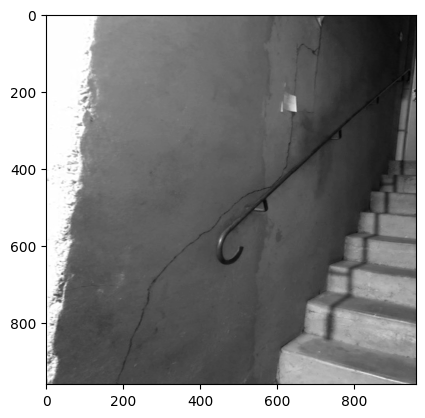

Label: 1


In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0].squeeze()
label = train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# net = models.resnet18(pretrained=True)
# num_ftrs = net.fc.in_features
# net.fc = nn.Linear(num_ftrs, 2)
# net.to(device)

net = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [17]:
len(train_dataloader)

250

In [18]:
train_loss = []
test_loss = []

In [19]:
for epoch in range(30):  

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs[0], labels)
        loss.backward()

        running_loss += loss.item()
    print(f'epoch:{epoch+1} loss:{running_loss / len(train_dataloader)}')
    train_loss.append(running_loss/len(train_dataloader))

# # Validation of test set
#     loss_test = 0
#     with torch.no_grad():
#         for data in test_dataloader:
#             images = data[0].to(device)
#             labels = data[1].to(device)
#             output = net(images)
#             loss = criterion(output, labels)
#             loss_test += loss.item()
#     test_loss.append(loss_test / len(test_dataloader))

print('Finished Training')

epoch:1 loss:0.7178957431316376
epoch:2 loss:0.7205735020637513
epoch:3 loss:0.7160905048847198
epoch:4 loss:0.7072035942077637
epoch:5 loss:0.71045290350914
epoch:6 loss:0.71563889670372
epoch:7 loss:0.7093274343013763
epoch:8 loss:0.7134126549959183
epoch:9 loss:0.7073481690883636
epoch:10 loss:0.7072992327213288
epoch:11 loss:0.7136663942337036
epoch:12 loss:0.7126053619384766
epoch:13 loss:0.714271849989891
epoch:14 loss:0.7145685222148895
epoch:15 loss:0.7108909778594971
epoch:16 loss:0.7082452847957611
epoch:17 loss:0.7091264734268189
epoch:18 loss:0.713773916721344
epoch:19 loss:0.7145276651382446
epoch:20 loss:0.708485339641571
epoch:21 loss:0.708518890619278
epoch:22 loss:0.7099705493450165
epoch:23 loss:0.7109724181890488
epoch:24 loss:0.711895001411438
epoch:25 loss:0.7166370613574982
epoch:26 loss:0.7142102587223053
epoch:27 loss:0.7115603162050247
epoch:28 loss:0.7170299998521805
epoch:29 loss:0.7082277827262878
epoch:30 loss:0.7121210613250732
Finished Training


<function matplotlib.pyplot.show(close=None, block=None)>

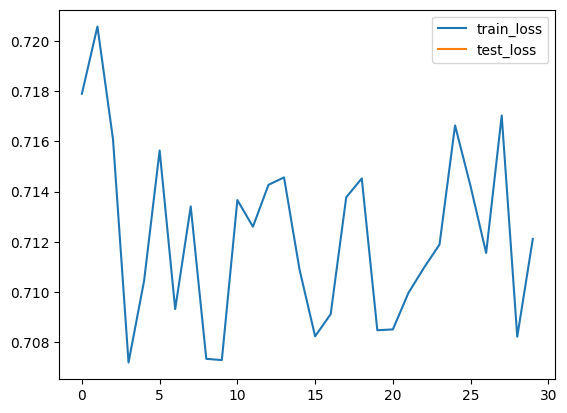

In [20]:
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.show

In [21]:
print(test_loss)

[]


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        images = images.to(torch.float)
        output = net(images)
        _, predicted = torch.max(output[0], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images:{100 * correct / total}%')
print('Number of train images:',total)

Accuracy of the network on the train images:47.394789579158314%
Number of train images: 998


In [25]:
classes =('0','1')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        images = images.to(torch.float)
        outputs = net(images)
        _, predictions = torch.max(outputs[0], 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(f'Accuracy of the network on the test images:{100 * correct / total}%')
print('Number of train images:',total)

Accuracy for class: 0     is 20.8 %
Accuracy for class: 1     is 83.7 %
Accuracy of the network on the test images:50.50709939148073%
Number of train images: 493


In [ ]:
PATH = './classification.pth'
torch.save(net.state_dict(), PATH)